-------------------------- Summary --------------------------------
              Treatment1    Treatment2    Difference
Raw life time: 8.0035        9.844         1.8405
-------------------------------------------------------------------



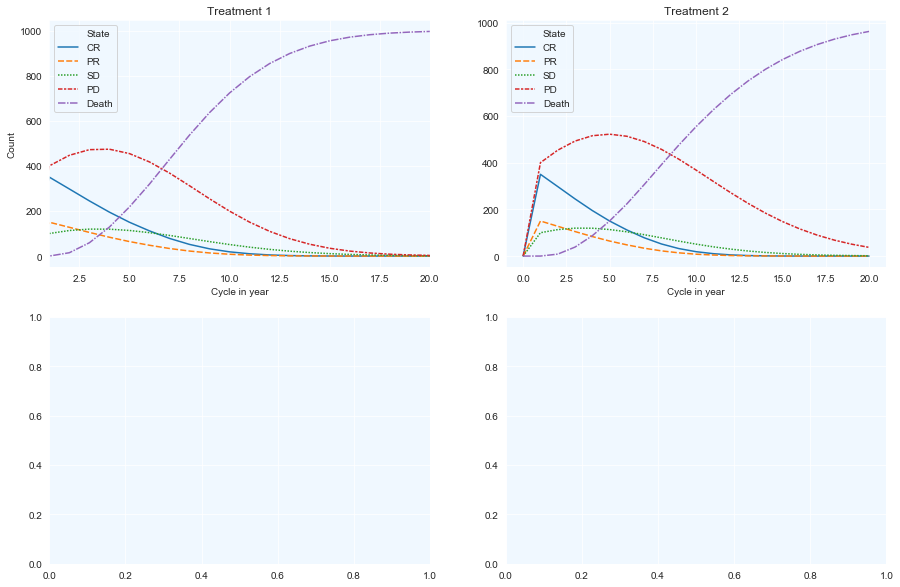

In [18]:
#https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e 
#from scipy import stats
from scipy.optimize import curve_fit
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 4
import warnings
warnings.filterwarnings('ignore')
#---------------------------------#
# Define parameter
#---------------------------------#
samplesize = 1000
cycles = 20
#CR/PR: Death rate- use survival model to predict
cph = CoxPHFitter()   
durations = [20,40,30,10,15,12,10,15,5, 1]
event_observed = [1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
os=np.transpose(pd.DataFrame([durations, event_observed]))
os.columns=['Time', 'Event']
cph.fit(os,'Time', event_col='Event')
p_cr_death=1 - cph.predict_survival_function(os,np.arange(0,cycles+1))[0]
p_pr_death = p_cr_death
#SD: Death rate- Weibull distribution (a-Shape, b-Scale)
a_sd=1
b_sd=60
p_sd_death = 1-np.exp(-(np.arange(0,cycles+1,1)/b_sd)**a_sd)
#PD: Death rate- Weibull distribution (a-Shape, b-Scale)
a_pd=1
b_pd=30
p_pd_death1 = 1-np.exp(-(np.arange(0,cycles+1,1)/b_pd)**a_pd)
p_pd_death2 = 1-np.exp(-(np.arange(0,cycles+1,1)/b_pd/2)**a_pd)
#Probability from CR/PR to SD/PD
p_cr_sd = 0.05
p_pr_sd = 0.05
p_cr_pd = 0.1
p_pr_pd = 0.1
p_sd_pd = 0.1

#---------------------------------#
# Define state
#---------------------------------#
stateName=['Pre', 'CR', 'PR', 'SD', 'PD', 'Death', 'Treatment', 'Cycle']
stateNum=len(stateName)-2
state1=np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
state2=np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
stateHist1=state1
stateHist2=state2
#---------------------------------#
# Define transition
#---------------------------------#
for i in range(cycles):
    #Treatment1
    P1 = np.array([[0.0, 0.35, 0.15, 0.1, 0.4, 0.0],
                  [0.0, (1 - p_cr_death[i] - p_cr_sd - p_cr_pd), 0.0, p_cr_sd, p_cr_pd, p_cr_death[i]],
                  [0.0, 0.0, (1 - p_pr_death[i] - p_pr_sd - p_pr_pd), p_pr_sd, p_pr_pd, p_pr_death[i]],
                  [0.0, 0.0, 0.0, (1-p_sd_death[i] - p_sd_pd), p_sd_pd, p_sd_death[i]],
                  [0.0, 0.0, 0.0, 0.0, (1-p_pd_death1[i]), p_pd_death1[i]],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.00]])
    state1=np.round(np.dot(state1,P1), decimals=4)
    stateHist1=np.append(stateHist1,state1,axis=0)
    #Treatment2
    P2 = np.array([[0.0, 0.35, 0.15, 0.1, 0.4, 0.0],
                  [0.0, (1 - p_cr_death[i] - p_cr_sd - p_cr_pd), 0.0, p_cr_sd, p_cr_pd, p_cr_death[i]],
                  [0.0, 0.0, (1 - p_pr_death[i] - p_pr_sd - p_pr_pd), p_pr_sd, p_pr_pd, p_pr_death[i]],
                  [0.0, 0.0, 0.0, (1-p_sd_death[i] - p_sd_pd), p_sd_pd, p_sd_death[i]],
                  [0.0, 0.0, 0.0, 0.0, (1-p_pd_death2[i]), p_pd_death2[i]],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.00]])
    state2=np.round(np.dot(state2,P2), decimals=4)
    stateHist2=np.append(stateHist2,state2,axis=0)
stateHist1=np.append(stateHist1, np.repeat(1,cycles+1).reshape(cycles+1,1), axis=1) #Add Treatment index
stateHist1=np.append(stateHist1, np.arange(0,cycles+1).reshape(cycles+1,1), axis=1) #Add cycles
stateHist2=np.append(stateHist2, np.repeat(2,cycles+1).reshape(cycles+1,1), axis=1) #Add Treatment index
stateHist2=np.append(stateHist2, np.arange(0,cycles+1).reshape(cycles+1,1), axis=1) #Add cycles
dfDistrHist = pd.DataFrame(np.append(stateHist1, stateHist2, axis=0))
dfDistrHist.columns=stateName
countHist = dfDistrHist*samplesize
countHist.Treatment=countHist.Treatment/samplesize
countHist.Cycle=countHist.Cycle/samplesize
count=countHist[[stateName[0], 'Treatment', 'Cycle']]
count['State']='Pre'
for state in np.arange(stateNum):
    count_a=countHist[[stateName[state], 'Treatment', 'Cycle']]
    count_a['State']=stateName[state]
    count=np.append(count,count_a, axis=0)
count=pd.DataFrame(count)
count.columns=['Value','Treatment','Cycle','State']
count.Value=count.Value.astype('float64')      #Convert 'object' to 'float' 
#count.Cycle=count.Cycle.astype('int')      #Convert 'object' to 'float'

#life time
def func(x, a, b):
    return np.exp(-(x/a)**b)  #Weibull distribution for CDF
def ltfun(dfDistrHist,Treatment):
    xdata=np.linspace(0,cycles,cycles+1)
    ydata=dfDistrHist[dfDistrHist['Treatment']==Treatment]
    ydata=np.concatenate((1-ydata[['Death']]).to_numpy())  #Surve rate from the transition
    popt, pcov=curve_fit(func, xdata, ydata)               #Estimate the parameter(shape and scale)
    xdata=np.linspace(0,cycles,cycles*10)                  #Break down the cycles for accuracy
    ydata=np.exp(-(xdata/popt[0])**popt[1])                #Use the shape and scale to estimate the survival rate 
    lifetime=round(np.trapz(ydata,x=xdata),4)              #Calcualte the area under the curve
    return lifetime
lifetime1=ltfun(dfDistrHist,1)
lifetime2=ltfun(dfDistrHist,2)
dif_lf=round(lifetime2-lifetime1, 4)

print("-------------------------- Summary --------------------------------")
print("             ", "Treatment1", "  ", "Treatment2", "  ", "Difference")  
print("Raw life time:", lifetime1, "      ", lifetime2, "       ", dif_lf)  
print("-------------------------------------------------------------------")

#-------------------
# Plots
#-------------------
sns.set_style('darkgrid', {"axes.facecolor":"aliceblue"}) #white, whitegrid, dark, darkgrid
fig, axes = plt.subplots(2, 2, figsize=(15,10))
#plot[0,0]
print()
plot=sns.lineplot(x='Cycle', y='Value', data=count[(count['Treatment']==1) & (count['State']!=stateName[0])], \
                    hue='State', style='State', err_style=None, ax=axes[0, 0]).set_title('Treatment 1')
axes[0,0].set_xlabel("Cycle in year")
axes[0,0].set_ylabel("Count")
axes[0,0].set_xlim(1,20,1)

#plot[0,1]
plot2=sns.lineplot(x='Cycle', y='Value', data=count[(count['Treatment']==2) & (count['State']!=stateName[0])], \
                    hue='State', style='State', err_style=None, ax=axes[0, 1]).set_title('Treatment 2')
axes[0,1].set_xlabel("Cycle in year")
axes[0,1].set_ylabel(" ")

plt.show()

In [16]:
#Print dependences for computational environment
#pip install watermark
import watermark
%load_ext watermark
%watermark -v -m -p scipy,lifelines,pandas,numpy,matplotlib,seaborn,watermark
print(" ")
%watermark -u -n -t -z


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.7.6
IPython 7.12.0

scipy 1.4.1
lifelines 0.24.13
pandas 1.0.1
numpy 1.18.1
matplotlib 3.1.3
seaborn 0.10.0
watermark 2.0.2

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 78 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit
 
last updated: Thu Jun 25 2020 13:36:03 Central Daylight Time
